# Integrantes
- Daniel Diab
- Laura Martinez

# 1. Preparación Datos
## 1.1. Importar Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## 1.2. Cargar Datos

In [3]:
df = pd.read_csv('./data.csv', sep=',', header=0)
datos = df.copy()

## 1.3. Eliminar Duplicados

In [5]:
import pandas as pd

def corregir_fechas(df, col="Date of Service"):
    df = df.copy()

    s = df[col].astype("string").str.strip()
    s = s.replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA, "null": pd.NA, "None": pd.NA})

    # pandas moderno: resuelve formatos mixtos de forma fiable
    try:
        dt = pd.to_datetime(s, errors="coerce", format="mixed", dayfirst=True)
    except TypeError:
        dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
        m = dt.isna() & s.notna()
        dt.loc[m] = pd.to_datetime(s[m], errors="coerce", dayfirst=False)

    df[col] = dt.dt.normalize() #solo fecha, no hora
    return df

datos = corregir_fechas(datos, "Date of Service")
print("Fechas inválidas:", datos["Date of Service"].isna().sum())

Fechas inválidas: 0


In [6]:
print("Duplicados exactos:", datos.duplicated().sum())

Duplicados exactos: 151


In [7]:
datos = datos.drop_duplicates()
datos.shape

(1488, 24)

In [8]:
cols_llave = ["Patient ID", "Date of Service"]

conflict_keys = datos.loc[
    datos.duplicated(subset=cols_llave, keep=False), cols_llave].drop_duplicates()

print("Llaves conflictivas:", len(conflict_keys))

datos = datos.merge(conflict_keys, on=cols_llave, how="left", indicator=True)
datos = datos[datos["_merge"] == "left_only"].drop(columns="_merge")

print("Filas restantes:", len(datos))

Llaves conflictivas: 112
Filas restantes: 1264


In [9]:
# Variable objetivo
target = "CVD Risk Score"

print("Filas antes de eliminar NaN en target:", len(datos))
print("NaN en target:", datos[target].isna().sum())

# Eliminar filas sin variable objetivo
datos = datos.dropna(subset=[target]).copy()

print("Filas después de eliminar NaN en target:", len(datos))
print("NaN en target ahora:", datos[target].isna().sum())

Filas antes de eliminar NaN en target: 1264
NaN en target: 27
Filas después de eliminar NaN en target: 1237
NaN en target ahora: 0


## 1.4. Separar Dataset

In [10]:
from sklearn.model_selection import train_test_split

X = datos.drop(columns=["CVD Risk Score", "CVD Risk Level"], errors="ignore")
y = datos["CVD Risk Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 1.5. Pipeline

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

In [12]:
cols_to_drop = ["Patient ID", "Date of Service", "CVD Risk Level", "Blood Pressure (mmgHg)"]

def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors="ignore")

dropper = FunctionTransformer(drop_columns)

In [13]:
def _to_num(s):
    return pd.to_numeric(s, errors="coerce")

def completar_bp_desde_texto(df, col_bp_texto="Blood Pressure (mmHg)", col_sis="Systolic BP", col_dia="Diastolic BP"):
    df = df.copy()
    if col_bp_texto not in df.columns:
        return df

    s = df[col_bp_texto].astype("string").str.strip()
    extra = s.str.extract(r"^\s*(\d+)\s*/\s*(\d+)\s*$")
    sys = _to_num(extra[0])
    dia = _to_num(extra[1])

    if col_sis in df.columns:
        m = df[col_sis].isna() & sys.notna()
        df.loc[m, col_sis] = sys.loc[m]

    if col_dia in df.columns:
        m = df[col_dia].isna() & dia.notna()
        df.loc[m, col_dia] = dia.loc[m]

    return df

tr_completar_bp = FunctionTransformer(completar_bp_desde_texto)


def corregir_swap_bp(df, col_sis="Systolic BP", col_dia="Diastolic BP"):
    df = df.copy()
    if col_sis not in df.columns or col_dia not in df.columns:
        return df

    sis = _to_num(df[col_sis])
    dia = _to_num(df[col_dia])

    m = sis.notna() & dia.notna() & (dia > sis)
    if m.any():
        df.loc[m, col_sis], df.loc[m, col_dia] = dia.loc[m].values, sis.loc[m].values

    return df

tr_swap_bp = FunctionTransformer(corregir_swap_bp)


def completar_altura_m_cm(df, col_h_m="Height (m)", col_h_cm="Height (cm)"):
    df = df.copy()
    if col_h_m not in df.columns or col_h_cm not in df.columns:
        return df

    hm = _to_num(df[col_h_m])
    hcm = _to_num(df[col_h_cm])

    # si falta cm y hay m
    m1 = hm.notna() & hcm.isna()
    df.loc[m1, col_h_cm] = hm.loc[m1] * 100

    # si falta m y hay cm
    m2 = hm.isna() & hcm.notna()
    df.loc[m2, col_h_m] = hcm.loc[m2] / 100

    return df

tr_altura_completar = FunctionTransformer(completar_altura_m_cm)


def resolver_inconsistencia_altura(df, col_h_m="Height (m)", col_h_cm="Height (cm)", tol_cm=1.0):
    df = df.copy()
    if col_h_m not in df.columns or col_h_cm not in df.columns:
        return df

    hm = _to_num(df[col_h_m])
    hcm = _to_num(df[col_h_cm])

    m = hm.notna() & hcm.notna() & (abs(hcm - hm * 100) > tol_cm)
    if m.any():
        df.loc[m, col_h_cm] = hm.loc[m] * 100

    return df

tr_altura_resolver = FunctionTransformer(resolver_inconsistencia_altura)


def recalcular_bmi(df, col_peso="Weight", col_h_m="Height (m)", col_bmi="BMI"):
    df = df.copy()
    if col_peso not in df.columns or col_h_m not in df.columns or col_bmi not in df.columns:
        return df

    w = _to_num(df[col_peso])
    hm = _to_num(df[col_h_m])

    m = w.notna() & hm.notna() & (hm > 0)
    df.loc[m, col_bmi] = w.loc[m] / (hm.loc[m] ** 2)

    return df

tr_bmi = FunctionTransformer(recalcular_bmi)


def recalcular_waist_height_ratio(df, col_cintura="Abdominal Circumference (cm)", col_h_cm="Height (cm)", col_ratio="Waist-to-Height Ratio"):
    df = df.copy()
    if col_cintura not in df.columns or col_h_cm not in df.columns or col_ratio not in df.columns:
        return df

    cintura = _to_num(df[col_cintura])
    hcm = _to_num(df[col_h_cm])

    m = cintura.notna() & hcm.notna() & (hcm > 0)
    df.loc[m, col_ratio] = cintura.loc[m] / hcm.loc[m]

    return df

tr_ratio = FunctionTransformer(recalcular_waist_height_ratio)

def clip_iqr_array(X, factor=1.5):
    X = np.asarray(X, dtype=float)

    q1 = np.nanpercentile(X, 25, axis=0)
    q3 = np.nanpercentile(X, 75, axis=0)
    iqr = q3 - q1

    lower = q1 - factor * iqr
    upper = q3 + factor * iqr

    return np.clip(X, lower, upper)

clipper_transformer = FunctionTransformer(clip_iqr_array)

In [14]:
numeric_features = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "Height (cm)",
    "BMI",
    "Abdominal Circumference (cm)",
    "Waist-to-Height Ratio",
    "Systolic BP",
    "Diastolic BP",
    "Total Cholesterol (mg/dL)",
    "HDL (mg/dL)",
    "Estimated LDL (mg/dL)",
    "Fasting Blood Sugar (mg/dL)",
]

#Variables categóricas
binary_features = [
    "Sex",
    "Smoking Status",
    "Diabetes Status",
    "Family History of CVD",
]

ordinal_features = [
    "Physical Activity Level",
]

nominal_features = [
    "Blood Pressure Category",
]

In [15]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("clipper", clipper_transformer),
    ("scaler", StandardScaler()),
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
])

ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[["Low", "Moderate", "High"]])),
])

nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bin", binary_transformer, binary_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("nom", nominal_transformer, nominal_features),
    ],
    remainder="drop"
)

In [17]:
from sklearn.pipeline import Pipeline

pipeline_preparacion = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),

    # determinísticas (en el orden correcto)
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    # no determinísticas (aprenden en fit): imputación + clipping + escalado + encoding
    ("preprocesamiento", preprocessor),
])

pipeline_preparacion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('bp_fill', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function com...001ECB7F55B10>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments to pas

In [18]:
from sklearn.linear_model import LinearRegression

pipeline_regresion = Pipeline(steps=[
    ("preparacion", pipeline_preparacion),
    ("modelo", LinearRegression())
])

pipeline_regresion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preparacion', ...), ('modelo', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('bp_fill', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function com...001ECB7F55B10>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse t

In [19]:
pipeline_regresion.fit(X_train, y_train)

modelo = pipeline_regresion.named_steps["modelo"]
print("Número de coeficientes:", len(modelo.coef_))

Número de coeficientes: 22


In [20]:
y_train_pred = pipeline_regresion.predict(X_train)
y_test_pred  = pipeline_regresion.predict(X_test)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def reporte_metricas(y_true, y_pred, nombre=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {nombre} ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
    print()

reporte_metricas(y_train, y_train_pred, "Train")
reporte_metricas(y_test, y_test_pred, "Test")

--- Train ---
MAE:  3.1365
RMSE: 10.7059
R2:   0.0755

--- Test ---
MAE:  3.0179
RMSE: 10.2431
R2:   0.0124



In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(927, 22)
(927,)
(310, 22)
(310,)


## Polinomial
Con el fin de poder continunar con las actividades, empezaremos por construir un moedo polinomial.

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

Para poder comenzar realizaremos un nuevo pipeline para la polinomial, considerando que lo aplicamos es a las variables númericas, a las categoricas no tiene sentido ...

In [24]:
numeric_transform_polinomial = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("clipper", clipper_transformer),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
])

preprocessor_polinomial = ColumnTransformer(
    transformers=[
        ("num", numeric_transform_polinomial, numeric_features),
        ("bin", binary_transformer, binary_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("nom", nominal_transformer, nominal_features),
    ],
    remainder="drop"
)

pipeline_polinomial = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),

    # determinísticas (en el orden correcto)
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    # no determinísticas (aprenden en fit): imputación + clipping + escalado + encoding
    ("preprocesamiento", preprocessor_polinomial),
    ("modelo", LinearRegression())
])

Para evaluar cómo influye la complejidad del modelo en su desempeño, se realizará una búsqueda del grado del polinomio utilizando GridSearchCV con validación cruzada.

El grado controla la flexibilidad del modelo: valores bajos generan modelos más simples, mientras que valores altos permiten capturar relaciones más complejas.

Mediante validación cruzada se seleccionará automáticamente el grado que obtenga mejor desempeño promedio en términos de RMSE, evitando elegirlo de forma arbitraria.

In [30]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import KFold

param_grid = {
    "preprocesamiento__num__poly__degree": [1,2,3,4],
    "preprocesamiento__num__scaler": [
        StandardScaler(),
        RobustScaler(),
        MinMaxScaler(),
        MaxAbsScaler(),
        PowerTransformer(method="yeo-johnson"),
        QuantileTransformer(output_distribution="normal"),
        QuantileTransformer(output_distribution="uniform"),
        "passthrough"
    ]
}

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

grid = GridSearchCV(
    estimator=pipeline_polinomial,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42), #kfold cross validation con 5 folds
    scoring=scoring, #como se maximiza, y el error queremos es el mínimo, pues se pone negativo
    refit="rmse",
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

grid.fit(X_train, y_train)

print("Mejor configuración:", grid.best_params_)
print("Mejor RMSE CV (neg):", -grid.best_score_)

# --- Tabla con resultados CV por combinación ---
res = pd.DataFrame(grid.cv_results_)

def scaler_name(x):
    if x == "passthrough":
        return "passthrough"
    return x.__class__.__name__

tabla = pd.DataFrame({
    "degree": res["param_preprocesamiento__num__poly__degree"].astype(int),
    "scaler": res["param_preprocesamiento__num__scaler"].apply(scaler_name),

    # CV (test) mean/std
    "RMSE_CV_mean": -res["mean_test_rmse"],
    "RMSE_CV_std":  res["std_test_rmse"],

    "MAE_CV_mean":  -res["mean_test_mae"],
    "MAE_CV_std":   res["std_test_mae"],

    "R2_CV_mean":    res["mean_test_r2"],
    "R2_CV_std":     res["std_test_r2"],

    # (opcional) Train CV mean/std (promedios de folds en train)
    "RMSE_train_mean": -res["mean_train_rmse"],
    "MAE_train_mean":  -res["mean_train_mae"],
    "R2_train_mean":    res["mean_train_r2"],
})

tabla = tabla.sort_values(["RMSE_CV_mean", "MAE_CV_mean"], ascending=[True, True]).reset_index(drop=True)

display(tabla.head(20))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejor configuración: {'preprocesamiento__num__poly__degree': 1, 'preprocesamiento__num__scaler': QuantileTransformer(output_distribution='normal')}
Mejor RMSE CV (neg): 10.864762016020341


c:\Users\Admin\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\preprocessing\_data.py:2885: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


,degree,scaler,RMSE_CV_mean,RMSE_CV_std,MAE_CV_mean,MAE_CV_std,R2_CV_mean,R2_CV_std,RMSE_train_mean,MAE_train_mean,R2_train_mean
0,1,QuantileTransformer,10.864762,1.649315,3.418810,0.184179,0.017911,0.038840,1.066545e+01,3.305306e+00,0.081397
1,1,MinMaxScaler,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
2,1,RobustScaler,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
3,1,StandardScaler,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
4,1,MaxAbsScaler,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
5,1,passthrough,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
6,1,QuantileTransformer,10.866548,1.667316,3.354814,0.191542,0.018590,0.030535,1.065385e+01,3.247803e+00,0.083465
7,1,PowerTransformer,10.873160,1.660247,3.395894,0.205607,0.016490,0.042174,1.066419e+01,3.258527e+00,0.081652
8,2,QuantileTransformer,11.362281,1.503756,4.861519,0.327074,-0.085397,0.101393,9.989590e+00,4.292531e+00,0.194052
9,2,PowerTransformer,12.338692,1.105965,5.131396,0.240137,-0.318878,0.304159,9.926151e+00,4.044880e+00,0.203975


In [31]:
mejor_modelo = grid.best_estimator_

y_pred_train = mejor_modelo.predict(X_train)
y_pred_test  = mejor_modelo.predict(X_test)

def metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_tr, mae_tr, r2_tr = metricas(y_train, y_pred_train)
rmse_te, mae_te, r2_te = metricas(y_test, y_pred_test)

print("\n--- Mejor modelo ---")
print("TRAIN  | RMSE:", rmse_tr, "| MAE:", mae_tr, "| R2:", r2_tr)
print("TEST   | RMSE:", rmse_te, "| MAE:", mae_te, "| R2:", r2_te)


--- Mejor modelo ---
TRAIN  | RMSE: 10.692976295775674 | MAE: 3.2425568598355587 | R2: 0.07774455560618143
TEST   | RMSE: 10.23853416790113 | MAE: 3.1473453077124134 | R2: 0.0132428343207045


El mejor modelo encontrado corresponde a un polinomio de grado 1, lo que sugiere que incrementar la complejidad no mejora el desempeño bajo validación cruzada. Además, la cercanía entre los errores de entrenamiento y prueba indica ausencia de sobreajuste; sin embargo, el R² en prueba es muy bajo, lo cual sugiere limitada capacidad explicativa con las variables actuales.

## Curvas de validación

Con el fin de analizar cómo la complejidad del modelo afecta su desempeño, se generan curvas de validación en función del grado del polinomio.

Para cada grado, se calcula el error promedio en validación cruzada junto con su desviación estándar, lo que permite evaluar tanto el desempeño medio como la variabilidad del modelo.

Esto permite identificar el punto a partir del cual aumentar la complejidad comienza a producir sobreajuste, en términos del trade-off sesgo-varianza.

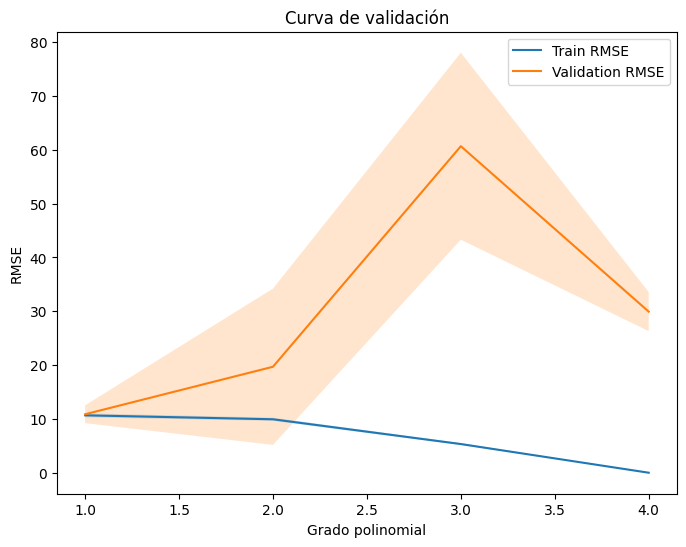

,grado,RMSE_train_mean,RMSE_train_std,RMSE_CV_mean,RMSE_CV_std,gap(CV-Train)
0,1,1.066545e+01,3.686990e-01,10.864762,1.649315,0.199308
1,2,9.930308e+00,2.958945e-01,19.688891,14.519124,9.758583
2,3,5.327572e+00,1.718146e-01,60.670428,17.367808,55.342857
3,4,4.893562e-13,2.591178e-13,29.929695,3.625561,29.929695


In [33]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import validation_curve

# 1) Fijar el mejor escalador encontrado por GridSearch (así solo varía el grado)
best_scaler = grid.best_params_["preprocesamiento__num__scaler"]

pipeline_para_curva = pipeline_polinomial.set_params(
    preprocesamiento__num__scaler=best_scaler
)

# 2) Rango de grados a evaluar
param_range = [1, 2, 3, 4]

# 3) validation_curve con RMSE (recuerda: sklearn lo devuelve NEGATIVO)
train_scores, val_scores = validation_curve(
    pipeline_para_curva,
    X_train,
    y_train,
    param_name="preprocesamiento__num__poly__degree",
    param_range=param_range,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# 4) Convertir a RMSE positivo
train_rmse = -train_scores
val_rmse   = -val_scores

train_mean = train_rmse.mean(axis=1)
train_std  = train_rmse.std(axis=1)

val_mean   = val_rmse.mean(axis=1)
val_std    = val_rmse.std(axis=1)

# 5) Graficar curvas + variabilidad (banda)
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Train RMSE")
plt.plot(param_range, val_mean, label="Validation RMSE")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.xlabel("Grado polinomial")
plt.ylabel("RMSE")
plt.title("Curva de validación")
plt.legend()
plt.show()

# 6) Tabla de soporte para el informe
import pandas as pd

tabla_curva = pd.DataFrame({
    "grado": param_range,
    "RMSE_train_mean": train_mean,
    "RMSE_train_std": train_std,
    "RMSE_CV_mean": val_mean,
    "RMSE_CV_std": val_std,
    "gap(CV-Train)": val_mean - train_mean
})

display(tabla_curva)

Los resultados muestran que para grado 1 (modelo lineal), el RMSE en entrenamiento y validación es muy similar, con una diferencia mínima entre ambas curvas. Esto indica un modelo estable, con baja varianza y adecuada capacidad de generalización. Aunque el modelo es relativamente simple, logra un equilibrio apropiado entre ajuste y estabilidad.

Al aumentar el grado a 2, el error en entrenamiento disminuye ligeramente, pero el error en validación aumenta de forma considerable y presenta mayor variabilidad entre particiones. Esta divergencia entre ambas curvas constituye la primera evidencia de sobreajuste. El modelo comienza a capturar patrones específicos del conjunto de entrenamiento que no se generalizan adecuadamente.

Para grados 3 y 4, el fenómeno se intensifica. El error de entrenamiento disminuye drásticamente, llegando prácticamente a cero en grado 4, mientras que el error de validación se incrementa de manera significativa. La brecha entre ambas curvas crece de forma pronunciada, lo que evidencia un aumento marcado de la varianza. En estos grados, el modelo dispone de un espacio de hipótesis demasiado amplio y termina memorizando los datos de entrenamiento en lugar de aprender relaciones generales.

El comportamiento observado refleja claramente el dilema sesgo–varianza. A medida que aumenta el grado polinomial, crece la complejidad del modelo y se amplía el espacio de hipótesis. Esto reduce el sesgo, ya que el modelo puede ajustarse con mayor precisión a los datos de entrenamiento, pero incrementa la varianza, deteriorando la capacidad de generalización.

En este caso, el grado 1 ofrece el mejor balance entre sesgo y varianza. Los modelos de mayor grado presentan sesgo bajo pero varianza alta, lo que conduce a sobreajuste. Por tanto, incrementar la complejidad no mejora el desempeño predictivo en validación cruzada, sino que introduce inestabilidad y pérdida de capacidad de generalización.

En conclusión, el análisis de las curvas de validación permite identificar que el sobreajuste comienza a evidenciarse a partir del grado 2, y que el modelo lineal constituye la opción más adecuada.

## Modelos con Regularización

Se implementan modelos de regresión lineal con regularización L2 (Ridge) y L1 (Lasso) usando pipelines.  
La regularización introduce una penalización controlada por el hiperparámetro `alpha`, que busca reducir el sobreajuste y mejorar la generalización.  
Se comparan los modelos sin regularización, Ridge y Lasso usando GridSearchCV (validación cruzada), explorando distintos valores de `alpha` y estrategias de escalamiento.  
Además, se analiza el efecto de la penalización sobre la magnitud de los coeficientes y, en Lasso, qué variables son llevadas exactamente a cero (selección automática de características).

In [36]:
from sklearn.linear_model import Ridge, Lasso

def scaler_name(x):
    if x == "passthrough":
        return "passthrough"
    return x.__class__.__name__

def construir_tabla_resultados(grid, prefix="preprocesamiento__num__"):
    res = pd.DataFrame(grid.cv_results_)
    return (
        pd.DataFrame({
            "degree": res[f"param_{prefix}poly__degree"].astype(int),
            "scaler": res[f"param_{prefix}scaler"].apply(scaler_name),
            "alpha":  res["param_modelo__alpha"].astype(float),

            "RMSE_CV_mean": -res["mean_test_rmse"],
            "RMSE_CV_std":   res["std_test_rmse"],

            "MAE_CV_mean":  -res["mean_test_mae"],
            "MAE_CV_std":    res["std_test_mae"],

            "R2_CV_mean":    res["mean_test_r2"],
            "R2_CV_std":     res["std_test_r2"],

            "RMSE_train_mean": -res["mean_train_rmse"],
            "MAE_train_mean":  -res["mean_train_mae"],
            "R2_train_mean":    res["mean_train_r2"],
        })
        .sort_values(["RMSE_CV_mean", "MAE_CV_mean"], ascending=[True, True])
        .reset_index(drop=True)
    )

def metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    RobustScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    PowerTransformer(method="yeo-johnson"),
    QuantileTransformer(output_distribution="normal"),
    QuantileTransformer(output_distribution="uniform"),
    "passthrough",
]

# Grid de penalización (alpha)
alphas = np.logspace(-4, 3, 12)  # 1e-4 ... 1e3

### Modelo Ridge (Regularización L2)

Ridge agrega una penalización L2 controlada por `alpha`, que tiende a reducir la magnitud de los coeficientes y mejorar la generalización sin llevarlos exactamente a cero.  

Se busca el mejor `alpha` con GridSearchCV y se prueban tanto distintos grados de polinomio como distintas estrategias de escalamiento.

In [37]:
pipeline_ridge = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    ("preprocesamiento", preprocessor_polinomial), 
    ("modelo", Ridge(random_state=42)),
])

param_grid_ridge = {
    "preprocesamiento__num__poly__degree": [1, 2, 3, 4],
    "preprocesamiento__num__scaler": scalers,
    "modelo__alpha": alphas,
}

grid_ridge = GridSearchCV(
    estimator=pipeline_ridge,
    param_grid=param_grid_ridge,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

grid_ridge.fit(X_train, y_train)

print("\n=== RIDGE ===")
print("Mejor configuración:", grid_ridge.best_params_)
print("Mejor RMSE CV:", -grid_ridge.best_score_)

tabla_ridge = construir_tabla_resultados(grid_ridge)
display(tabla_ridge.head(20))

mejor_ridge = grid_ridge.best_estimator_
y_pred_train_r = mejor_ridge.predict(X_train)
y_pred_test_r  = mejor_ridge.predict(X_test)

rmse_tr, mae_tr, r2_tr = metricas(y_train, y_pred_train_r)
rmse_te, mae_te, r2_te = metricas(y_test,  y_pred_test_r)

print("--- Mejor RIDGE ---")
print("TRAIN | RMSE:", rmse_tr, "| MAE:", mae_tr, "| R2:", r2_tr)
print("TEST  | RMSE:", rmse_te, "| MAE:", mae_te, "| R2:", r2_te)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits

=== RIDGE ===
Mejor configuración: {'modelo__alpha': np.float64(53.366992312063125), 'preprocesamiento__num__poly__degree': 2, 'preprocesamiento__num__scaler': MaxAbsScaler()}
Mejor RMSE CV: 10.779910585134402


,degree,scaler,alpha,RMSE_CV_mean,RMSE_CV_std,MAE_CV_mean,MAE_CV_std,R2_CV_mean,R2_CV_std,RMSE_train_mean,MAE_train_mean,R2_train_mean
0,2,MaxAbsScaler,53.366992,10.779911,1.731645,3.055973,0.189721,0.037308,0.020279,10.712822,2.989327,0.073255
1,2,MinMaxScaler,53.366992,10.780681,1.732051,3.057882,0.191957,0.037124,0.022101,10.703112,2.988154,0.074934
2,1,StandardScaler,231.012970,10.782092,1.783702,2.998191,0.241525,0.038795,0.024314,10.747144,2.948780,0.067337
3,1,QuantileTransformer,53.366992,10.782737,1.726071,3.099734,0.175756,0.036753,0.016753,10.743879,3.051087,0.067875
4,2,QuantileTransformer,231.012970,10.784119,1.792285,2.977914,0.229781,0.038863,0.022502,10.759460,2.938426,0.065209
5,1,RobustScaler,231.012970,10.784904,1.779422,3.014797,0.233903,0.038316,0.019926,10.779744,2.978595,0.061666
6,1,PowerTransformer,231.012970,10.785647,1.791151,3.017729,0.234324,0.038430,0.025281,10.745492,2.964519,0.067632
7,3,MaxAbsScaler,231.012970,10.785847,1.781314,2.986901,0.242221,0.038033,0.022605,10.746510,2.936584,0.067440
8,3,MinMaxScaler,231.012970,10.786152,1.782246,2.990426,0.240009,0.037989,0.023357,10.741271,2.939860,0.068350
9,1,RobustScaler,53.366992,10.786416,1.730842,3.085697,0.206069,0.035892,0.025368,10.694427,3.008514,0.076439


--- Mejor RIDGE ---
TRAIN | RMSE: 10.735860440684025 | MAE: 2.953636368153507 | R2: 0.07033231735433754
TEST  | RMSE: 10.149501911434518 | MAE: 2.758877851830947 | R2: 0.030329506799556594


En el caso de Ridge, la búsqueda de hiperparámetros seleccionó un modelo de grado 2 con una penalización relativamente alta (α ≈ 53). Esto es relevante porque indica que, al incorporar términos polinomiales (mayor complejidad), el modelo necesita una penalización fuerte para mantener estabilidad. En validación cruzada, el RMSE se mantiene alrededor de 10.7–10.8 y el R² promedio es bajo (≈ 0.03–0.04), con una desviación estándar reducida. Además, la diferencia entre el error de entrenamiento y el de validación es pequeña, lo que sugiere que no existe una brecha marcada de generalización.

Este comportamiento contrasta con el modelo polinomial sin regularización, donde al aumentar el grado el error de entrenamiento disminuía drásticamente mientras el de validación crecía, evidenciando alta varianza. Con Ridge, la penalización L2 reduce la magnitud de los coeficientes asociados a los términos polinomiales, evitando que el modelo “explote” en complejidad efectiva. En términos del trade-off sesgo–varianza, Ridge introduce algo más de sesgo pero reduce significativamente la varianza, logrando que un modelo de mayor grado (2) no incurra en sobreajuste severo.

Sin embargo, aunque la regularización controla el sobreajuste, no produce una mejora sustancial en capacidad predictiva. El R² sigue siendo bajo y el RMSE es muy similar al del modelo lineal regularizado. Esto sugiere que el problema no es simplemente de falta de complejidad, sino de limitada señal explicativa en los datos. En síntesis, Ridge sí permite incrementar la complejidad sin deteriorar la generalización, pero no convierte esa complejidad adicional en ganancias significativas de desempeño.

### Modelo Lasso
Lasso agrega una penalización L1 controlada por `alpha`. A diferencia de Ridge, Lasso puede llevar coeficientes exactamente a cero, funcionando como selección automática de características. Se busca el mejor `alpha` con GridSearchCV y se prueban distintas estrategias de escalamiento.

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

scalers_small = [
    MaxAbsScaler(),
    MinMaxScaler(),
    StandardScaler(),
    RobustScaler(),
]
alphas_small = np.logspace(-4, 1, 10)

pipeline_lasso = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    ("preprocesamiento", preprocessor_polinomial),
    ("modelo", Lasso(max_iter=20000, tol=1e-3, selection="random", random_state=42)),
])

param_grid_lasso = {
    "preprocesamiento__num__poly__degree": [1, 2, 3],
    "preprocesamiento__num__scaler": scalers_small,
    "modelo__alpha": alphas_small,
}

grid_lasso = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=param_grid_lasso,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

grid_lasso.fit(X_train, y_train)

print("\n=== LASSO (Grid reducido) ===")
print("Mejor configuración:", grid_lasso.best_params_)
print("Mejor RMSE CV:", -grid_lasso.best_score_)

mejor_lasso = grid_lasso.best_estimator_
y_pred_train = mejor_lasso.predict(X_train)
y_pred_test  = mejor_lasso.predict(X_test)

rmse_tr, mae_tr, r2_tr = metricas(y_train, y_pred_train)
rmse_te, mae_te, r2_te = metricas(y_test,  y_pred_test)

print("--- Mejor LASSO ---")
print("TRAIN | RMSE:", rmse_tr, "| MAE:", mae_tr, "| R2:", r2_tr)
print("TEST  | RMSE:", rmse_te, "| MAE:", mae_te, "| R2:", r2_te)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

=== LASSO (Grid reducido) ===
Mejor configuración: {'modelo__alpha': np.float64(0.21544346900318845), 'preprocesamiento__num__poly__degree': 1, 'preprocesamiento__num__scaler': RobustScaler()}
Mejor RMSE CV: 10.737287789921512
--- Mejor LASSO ---
TRAIN | RMSE: 10.78811809249306 | MAE: 2.928396832803698 | R2: 0.061259828138647276
TEST  | RMSE: 10.201550748309883 | MAE: 2.6302053128868486 | R2: 0.02035864658194053


In [44]:
tabla_lasso = construir_tabla_resultados(grid_lasso)
display(tabla_lasso.head(20))

,degree,scaler,alpha,RMSE_CV_mean,RMSE_CV_std,MAE_CV_mean,MAE_CV_std,R2_CV_mean,R2_CV_std,RMSE_train_mean,MAE_train_mean,R2_train_mean
0,1,RobustScaler,0.215443,10.737288,1.773015,2.991221,0.233095,0.046444,0.027395,10.754489,2.945383,0.066082
1,1,StandardScaler,0.215443,10.753810,1.768751,2.997241,0.238663,0.043164,0.028600,10.735786,2.932896,0.069314
2,1,MinMaxScaler,0.059948,10.759965,1.726319,3.132207,0.196912,0.040606,0.024674,10.724948,3.069449,0.071158
3,1,MaxAbsScaler,0.059948,10.763895,1.718667,3.150739,0.187321,0.039683,0.022246,10.738644,3.093759,0.068782
4,2,RobustScaler,0.215443,10.774721,1.773835,3.004395,0.237490,0.039558,0.027728,10.735716,2.938444,0.069299
5,2,StandardScaler,0.215443,10.779396,1.762661,3.008740,0.227508,0.038129,0.030095,10.718657,2.939511,0.072260
6,2,MinMaxScaler,0.059948,10.782842,1.722370,3.121864,0.196406,0.036263,0.024340,10.709292,3.045131,0.073850
7,2,MaxAbsScaler,0.059948,10.786048,1.720283,3.122813,0.191931,0.035594,0.024043,10.716024,3.049615,0.072689
8,2,MinMaxScaler,0.215443,10.791053,1.736383,3.185834,0.275782,0.035751,0.010659,10.839536,3.176024,0.051208
9,3,MinMaxScaler,0.059948,10.795073,1.707341,3.145746,0.189382,0.033378,0.026145,10.698979,3.058699,0.075625


In [52]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def _safe_get_names_from_pipe(pipe, input_features):
    """
    Devuelve nombres de salida de un Pipeline aunque el último paso
    (ej: clipper) no soporte get_feature_names_out.
    """
    if hasattr(pipe, "get_feature_names_out"):
        try:
            return pipe.get_feature_names_out(input_features)
        except AttributeError:
            pass

    # Si es Pipeline y el último no soporta nombres, lo quitamos
    if isinstance(pipe, Pipeline):
        for k in range(len(pipe.steps), 0, -1):
            sub = pipe[:k]
            if hasattr(sub, "get_feature_names_out"):
                try:
                    return sub.get_feature_names_out(input_features)
                except Exception:
                    continue

    # Fallback: si de verdad no se puede, devolvemos los input_features
    return np.array(input_features, dtype=object)

def get_feature_names_out_robusto(preprocessor):
    """
    Funciona con ColumnTransformer + Pipelines internos aunque haya pasos
    sin get_feature_names_out (ej: clipper).
    """
    if not isinstance(preprocessor, ColumnTransformer):
        # si fuera un Pipeline “normal”
        if hasattr(preprocessor, "get_feature_names_out"):
            return preprocessor.get_feature_names_out()
        raise TypeError("Se esperaba un ColumnTransformer o algo con get_feature_names_out.")

    # Nombres de entrada (si X era DataFrame, esto suele existir)
    if hasattr(preprocessor, "feature_names_in_"):
        input_all = np.array(preprocessor.feature_names_in_, dtype=object)
    else:
        # si X fue numpy, no hay nombres reales
        raise ValueError("No hay feature_names_in_. Usa X como DataFrame para nombres reales.")

    out_names = []

    for name, trans, cols in preprocessor.transformers_:
        if trans == "drop":
            continue

        # Resolver columnas a nombres
        if cols is None:
            col_names = input_all
        else:
            # cols puede ser lista de strings, índices, slice, etc.
            if isinstance(cols, slice):
                col_names = input_all[cols]
            else:
                col_names = np.array([input_all[c] if isinstance(c, (int, np.integer)) else c for c in cols], dtype=object)

        if trans == "passthrough":
            out_names.extend(col_names.tolist())
            continue

        # Pipeline / transformer con nombres
        if isinstance(trans, Pipeline):
            names = _safe_get_names_from_pipe(trans, col_names)
        else:
            if hasattr(trans, "get_feature_names_out"):
                names = trans.get_feature_names_out(col_names)
            else:
                names = col_names  # fallback

        out_names.extend(list(names))

    return np.array(out_names, dtype=object)

pre = mejor_lasso.named_steps["preprocesamiento"]
model = mejor_lasso.named_steps["modelo"]

feature_names = get_feature_names_out_robusto(pre)
coef = np.ravel(model.coef_)

df_coef = (pd.DataFrame({"feature": feature_names, "coef": coef, "abs_coef": np.abs(coef)}).sort_values("abs_coef", ascending=False))

display(df_coef.head(30))

# Variables “seleccionadas” por Lasso (coef != 0)
seleccion = df_coef[df_coef["coef"] != 0].copy()
display(seleccion.head(30))
print(f"Total features: {len(df_coef)} | No-cero (seleccionadas): {len(seleccion)}")

,feature,coef,abs_coef
15,Diabetes Status_Y,2.394977,2.394977
4,BMI,2.266799,2.266799
7,Systolic BP,1.453254,1.453254
11,Estimated LDL (mg/dL),0.070604,0.070604
14,Smoking Status_Y,0.055015,0.055015
0,Age,-0.008655,0.008655
5,Abdominal Circumference (cm),0.000000,0.000000
3,Height (cm),-0.000000,0.000000
2,Height (m),-0.000000,0.000000
1,Weight (kg),-0.000000,0.000000


,feature,coef,abs_coef
15,Diabetes Status_Y,2.394977,2.394977
4,BMI,2.266799,2.266799
7,Systolic BP,1.453254,1.453254
11,Estimated LDL (mg/dL),0.070604,0.070604
14,Smoking Status_Y,0.055015,0.055015
0,Age,-0.008655,0.008655


Total features: 22 | No-cero (seleccionadas): 6


En el caso de Lasso, la mejor configuración seleccionó grado 1 con α ≈ 0.21. Es decir, al combinar expansión polinomial con penalización L1, el modelo óptimo no incorporó términos de mayor grado. Esto es conceptualmente importante: Lasso no solo penaliza la magnitud de los coeficientes, sino que puede llevarlos exactamente a cero, realizando selección automática de características. El hecho de que el mejor modelo sea lineal indica que, bajo penalización L1, los términos polinomiales adicionales no aportan mejora estable y son descartados.

En validación cruzada, el RMSE es similar al de Ridge (≈ 10.7), pero el R² en test es ligeramente inferior. La brecha entre entrenamiento y test tampoco es grande, lo que indica que el modelo es estable y no presenta sobreajuste pronunciado. No obstante, a diferencia de Ridge, aquí la regularización no permitió sostener un modelo de mayor grado; más bien, redujo la complejidad efectiva al mantener solo términos lineales relevantes.

Desde el punto de vista del control del sobreajuste, Lasso actúa de manera más restrictiva que Ridge. En lugar de permitir mayor complejidad estabilizada, tiende a simplificar el modelo. Esto sugiere que, para este conjunto de datos, la complejidad polinomial adicional no es robusta y puede incluso introducir ruido que Lasso decide eliminar.


## Comparación
La regularización sí permite controlar el sobreajuste al incrementar la complejidad, especialmente en el caso de Ridge, donde fue posible utilizar grado 2 sin deterioro marcado en validación cruzada. Sin embargo, el aumento de complejidad no se traduce en mejoras relevantes de desempeño. En Lasso, el propio proceso de regularización evita que la complejidad crezca innecesariamente, seleccionando un modelo lineal como óptimo.

Por tanto, la evidencia empírica muestra que la regularización controla la varianza inducida por la expansión polinomial, pero también revela que mayor complejidad no implica necesariamente mejor generalización. En este problema, el límite del desempeño parece estar determinado más por la información contenida en las variables que por la flexibilidad del modelo.

## Modelo Final

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def metricas_basicas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

def extraer_cv(gridsearch):
    """
    Extrae métricas CV del mejor modelo usando los aliases del scoring dict:
    mean_test_rmse, mean_test_mae, mean_test_r2, etc.
    """
    res = gridsearch.cv_results_
    i = gridsearch.best_index_

    # RMSE y MAE vienen como negativos (por usar 'neg_*')
    rmse_mean = -res["mean_test_rmse"][i]
    rmse_std  =  res["std_test_rmse"][i]

    mae_mean  = -res["mean_test_mae"][i]
    mae_std   =  res["std_test_mae"][i]

    r2_mean   =  res["mean_test_r2"][i]
    r2_std    =  res["std_test_r2"][i]

    return rmse_mean, rmse_std, mae_mean, mae_std, r2_mean, r2_std

def resumen_modelo(nombre, gridsearch, X_train, X_test, y_train, y_test):
    best_model = gridsearch.best_estimator_

    # train/test
    y_tr_pred = best_model.predict(X_train)
    y_te_pred = best_model.predict(X_test)

    rmse_tr, mae_tr, r2_tr = metricas_basicas(y_train, y_tr_pred)
    rmse_te, mae_te, r2_te = metricas_basicas(y_test,  y_te_pred)

    # cv (del mejor)
    rmse_cv_mean, rmse_cv_std, mae_cv_mean, mae_cv_std, r2_cv_mean, r2_cv_std = extraer_cv(gridsearch)

    # hiperparámetros (para reportar claro)
    params = gridsearch.best_params_
    degree = params.get("preprocesamiento__num__poly__degree", None)
    scaler = params.get("preprocesamiento__num__scaler", None)
    alpha  = params.get("modelo__alpha", None)

    def scaler_name(s):
        if s is None:
            return None
        if s == "passthrough":
            return "passthrough"
        return s.__class__.__name__

    return {
        "Modelo": nombre,
        "degree": degree,
        "scaler": scaler_name(scaler),
        "alpha": float(alpha) if alpha is not None else None,

        "RMSE_CV_mean": rmse_cv_mean,
        "RMSE_CV_std":  rmse_cv_std,
        "MAE_CV_mean":  mae_cv_mean,
        "MAE_CV_std":   mae_cv_std,
        "R2_CV_mean":   r2_cv_mean,
        "R2_CV_std":    r2_cv_std,

        "RMSE_train": rmse_tr,
        "MAE_train":  mae_tr,
        "R2_train":   r2_tr,

        "RMSE_test": rmse_te,
        "MAE_test":  mae_te,
        "R2_test":   r2_te,

        "Brecha_RMSE_(test-train)": rmse_te - rmse_tr
    }

# === Construir tabla comparativa ===
resultados = []
resultados.append(resumen_modelo("Polinomial (sin reg.)", grid, X_train, X_test, y_train, y_test))
resultados.append(resumen_modelo("Ridge", grid_ridge, X_train, X_test, y_train, y_test))
resultados.append(resumen_modelo("Lasso", grid_lasso, X_train, X_test, y_train, y_test))

tabla_comparativa = pd.DataFrame(resultados)

# Orden sugerido: primero por RMSE_CV_mean (principal), luego por estabilidad (std), luego por test
tabla_comparativa = tabla_comparativa.sort_values(
    by=["RMSE_CV_mean", "RMSE_CV_std", "RMSE_test"],
    ascending=[True, True, True]
).reset_index(drop=True)

tabla_comparativa

,Modelo,degree,scaler,alpha,RMSE_CV_mean,RMSE_CV_std,MAE_CV_mean,MAE_CV_std,R2_CV_mean,R2_CV_std,RMSE_train,MAE_train,R2_train,RMSE_test,MAE_test,R2_test,Brecha_RMSE_(test-train)
0,Lasso,1,RobustScaler,0.215443,10.737288,1.773015,2.991221,0.233095,0.046444,0.027395,10.788118,2.928397,0.061260,10.201551,2.630205,0.020359,-0.586567
1,Ridge,2,MaxAbsScaler,53.366992,10.779911,1.731645,3.055973,0.189721,0.037308,0.020279,10.735860,2.953636,0.070332,10.149502,2.758878,0.030330,-0.586359
2,Polinomial (sin reg.),1,QuantileTransformer,NaN,10.864762,1.649315,3.418810,0.184179,0.017911,0.038840,10.692976,3.242557,0.077745,10.238534,3.147345,0.013243,-0.454442



El modelo seleccionado como mejor alternativa es el pipeline Polinomial + Ridge (grado = 2, α ≈ 53.37, MaxAbsScaler). Cuantitativamente, este modelo obtuvo el menor error en el conjunto de test (RMSE ≈ 10.15), superando tanto al modelo lineal sin regularización (RMSE test ≈ 10.24) como al modelo Lasso (RMSE test ≈ 10.20). En validación cruzada también presenta un desempeño competitivo (RMSE CV ≈ 10.78), con una desviación estándar moderada (≈ 1.73), lo que indica estabilidad entre folds. Además, la diferencia entre RMSE de entrenamiento (≈ 10.74) y de test (≈ 10.15) es pequeña, evidenciando buena generalización y ausencia de sobreajuste severo. En contraste, el modelo polinomial sin regularización mostró señales claras de alta varianza al aumentar el grado (brecha creciente train–validación), y aunque Lasso mejora ligeramente el error respecto al modelo base, no logra aprovechar de forma estable la expansión polinomial (su mejor modelo fue grado 1). Por tanto, el modelo Polinomial + Ridge logra el mejor equilibrio entre desempeño promedio, estabilidad (baja variabilidad en CV) y control de la complejidad, cumpliendo el criterio solicitado de considerar no solo el promedio de la métrica principal sino también su robustez.

## Bootstrapping
Para estimar la incertidumbre del desempeño del modelo seleccionado (Polinomial + Ridge), se aplicó bootstrapping con 1000 remuestreos sobre el conjunto de test y se construyeron intervalos de confianza al 95% para RMSE, MAE y R²

=== Métricas puntuales en TEST (modelo seleccionado) ===
RMSE: 10.149502 | MAE: 2.758878 | R2: 0.030330


,métrica,media_bootstrap,std_bootstrap,IC95%_lower,IC95%_upper,valor_test
0,RMSE,9.925646,2.531782,4.930738,14.410108,10.149502
1,MAE,2.781165,0.570532,1.808590,3.980208,2.758878
2,R2,0.036256,0.034558,-0.001422,0.101143,0.030330



=== Intervalos de confianza 95% (Bootstrap sobre test) ===
RMSE: media=9.9256 | IC95%=[4.9307, 14.4101] | std=2.5318 | test=10.1495
MAE: media=2.7812 | IC95%=[1.8086, 3.9802] | std=0.5705 | test=2.7589
R2: media=0.0363 | IC95%=[-0.0014, 0.1011] | std=0.0346 | test=0.0303


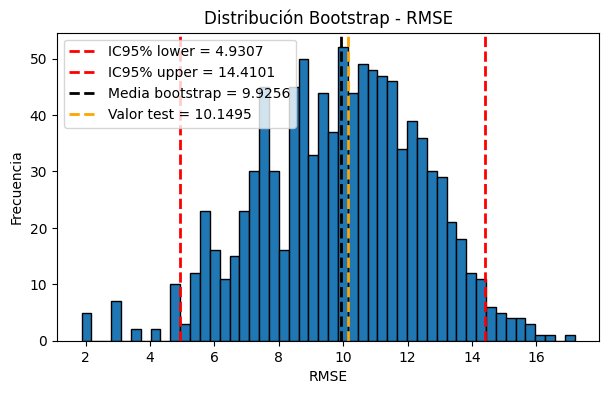

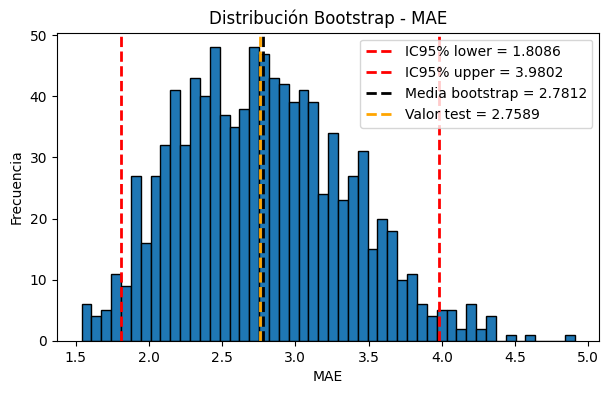

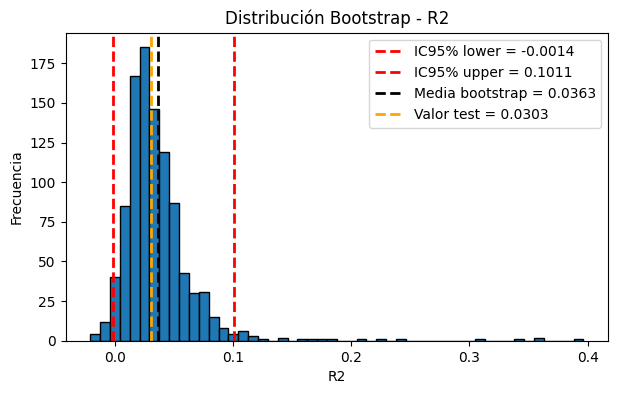

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_model = mejor_ridge
n_iterations = 1000          # >= 500
alpha_ci = 0.95
np.random.seed(42)

y_pred_test_full = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mae_test  = mean_absolute_error(y_test, y_pred_test_full)
r2_test   = r2_score(y_test, y_pred_test_full)

test_point = {"RMSE": rmse_test, "MAE": mae_test, "R2": r2_test}

print("=== Métricas puntuales en TEST (modelo seleccionado) ===")
print(f"RMSE: {rmse_test:.6f} | MAE: {mae_test:.6f} | R2: {r2_test:.6f}")


rmse_stats, mae_stats, r2_stats = [], [], []

for _ in range(n_iterations):
    X_resample, y_resample = resample(
        X_test, y_test,
        replace=True,
        n_samples=len(X_test))

    y_pred = best_model.predict(X_resample)

    rmse = np.sqrt(mean_squared_error(y_resample, y_pred))
    mae  = mean_absolute_error(y_resample, y_pred)
    r2   = r2_score(y_resample, y_pred)

    rmse_stats.append(rmse)
    mae_stats.append(mae)
    r2_stats.append(r2)

rmse_stats = np.array(rmse_stats)
mae_stats  = np.array(mae_stats)
r2_stats   = np.array(r2_stats)


p_lower = ((1.0 - alpha_ci) / 2.0) * 100
p_upper = (alpha_ci + (1.0 - alpha_ci) / 2.0) * 100

def resumen_ci(arr, nombre):
    lower = np.percentile(arr, p_lower)
    upper = np.percentile(arr, p_upper)
    mean  = np.mean(arr)
    std   = np.std(arr, ddof=1)
    return {
        "métrica": nombre,
        "media_bootstrap": mean,
        "std_bootstrap": std,
        "IC95%_lower": lower,
        "IC95%_upper": upper,
        "valor_test": test_point[nombre]
    }

tabla_ci = pd.DataFrame([
    resumen_ci(rmse_stats, "RMSE"),
    resumen_ci(mae_stats,  "MAE"),
    resumen_ci(r2_stats,   "R2"),
])

display(tabla_ci)

print("\n=== Intervalos de confianza 95% (Bootstrap sobre test) ===")
for _, row in tabla_ci.iterrows():
    print(
        f"{row['métrica']}: "
        f"media={row['media_bootstrap']:.4f} | "
        f"IC95%=[{row['IC95%_lower']:.4f}, {row['IC95%_upper']:.4f}] | "
        f"std={row['std_bootstrap']:.4f} | "
        f"test={row['valor_test']:.4f}"
    )

def plot_hist(arr, nombre, bins=50):
    lower = np.percentile(arr, p_lower)
    upper = np.percentile(arr, p_upper)
    mean  = np.mean(arr)
    testv = test_point[nombre]

    plt.figure(figsize=(7,4))
    plt.hist(arr, bins=bins, edgecolor="black")  # barras azules por default

    plt.axvline(lower, linestyle="--", linewidth=2, color="red",   label=f"IC95% lower = {lower:.4f}")
    plt.axvline(upper, linestyle="--", linewidth=2, color="red",   label=f"IC95% upper = {upper:.4f}")
    plt.axvline(mean,  linestyle="--", linewidth=2, color="black", label=f"Media bootstrap = {mean:.4f}")
    plt.axvline(testv, linestyle="--", linewidth=2, color="orange",label=f"Valor test = {testv:.4f}")

    plt.title(f"Distribución Bootstrap - {nombre}")
    plt.xlabel(nombre)
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

plot_hist(rmse_stats, "RMSE")
plot_hist(mae_stats,  "MAE")
plot_hist(r2_stats,   "R2")

En el caso del RMSE, la media bootstrap fue aproximadamente 9.93 y el intervalo estimado fue [4.93, 14.41], mientras que el valor puntual observado en test fue 10.15. El hecho de que este valor se encuentre muy cercano a la media de la distribución y claramente dentro del intervalo sugiere que el error reportado es coherente con la variabilidad muestral esperada. Sin embargo, la amplitud del intervalo indica que el nivel de error puede variar de manera apreciable si cambia la composición de los datos evaluados, lo que evidencia una variabilidad moderada en el desempeño.

Para el MAE, la media bootstrap fue cercana a 2.78, con un intervalo [1.81, 3.98], y el valor puntual en test fue 2.76. La distribución observada es relativamente concentrada y el valor puntual coincide estrechamente con la media, lo que indica consistencia en el error absoluto promedio. Esto sugiere que, aunque el modelo no alcanza un nivel alto de precisión, su comportamiento es relativamente estable frente a pequeñas variaciones en los datos de evaluación.

En cuanto al R², la media bootstrap fue aproximadamente 0.036 y el intervalo estimado fue [-0.001, 0.101], con un valor puntual en test de 0.030. La cercanía del límite inferior a cero refleja que la capacidad explicativa del modelo es limitada y sensible a la muestra considerada. En otras palabras, el bajo R² no parece ser producto de una partición particular del test, sino una característica consistente del modelo y del conjunto de variables disponibles.

En conjunto, el análisis bootstrap permite concluir que el modelo presenta estabilidad razonable en términos de error (RMSE y MAE), ya que los valores puntuales se alinean con la distribución empírica obtenida. No obstante, la amplitud de los intervalos, especialmente en RMSE, muestra que existe una variabilidad no despreciable en el desempeño, lo que implica que las predicciones deben interpretarse considerando esta incertidumbre.

In [57]:
import re
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

_PLACEHOLDER = "§§"  # para proteger espacios dentro de nombres originales

def _protect_spaces(cols):
    return [str(c).replace(" ", _PLACEHOLDER) for c in cols]

def _restore_spaces(s: str) -> str:
    return str(s).replace(_PLACEHOLDER, " ")

def _strip_prefix(s: str) -> str:
    # quita num__/bin__/cat__/...
    return re.sub(r"^[A-Za-z0-9_]+__", "", str(s))

def nombres_polinomiales_grado2(preprocessor: ColumnTransformer, X_df: pd.DataFrame, limpiar=True):
    """
    Extrae nombres completos del ColumnTransformer cuando hay PolynomialFeatures (grado>=2),
    incluyendo términos lineales, cuadrados e interacciones, SIN romper nombres con espacios.
    NO reentrena. Requiere X_df DataFrame.
    """
    if not isinstance(X_df, pd.DataFrame):
        raise ValueError("X_test/X_train debe ser un DataFrame para obtener nombres reales.")
    if not hasattr(preprocessor, "feature_names_in_"):
        raise ValueError("El preprocesador no tiene feature_names_in_. Asegúrate de haber fiteado con DataFrame.")

    input_cols = list(preprocessor.feature_names_in_)
    X_df = X_df[input_cols]  # mismo orden que en el fit

    out_names = []

    for block_name, trans, cols in preprocessor.transformers_:
        if trans == "drop":
            continue

        # Resolver cols a nombres reales
        if cols is None:
            cols_names = input_cols
        else:
            if isinstance(cols, slice):
                cols_names = input_cols[cols]
            else:
                cols_names = [input_cols[c] if isinstance(c, (int, np.integer)) else c for c in cols]

        if trans == "passthrough":
            out_names.extend([f"{block_name}__{c}" for c in cols_names])
            continue

        # Pipeline: buscar PolynomialFeatures u OneHotEncoder
        if isinstance(trans, Pipeline):
            poly = None
            ohe = None
            for _, step_obj in trans.steps:
                if isinstance(step_obj, PolynomialFeatures):
                    poly = step_obj
                if isinstance(step_obj, OneHotEncoder):
                    ohe = step_obj

            # --- PolynomialFeatures (aquí está el fix) ---
            if poly is not None:
                cols_safe = _protect_spaces(cols_names)  # "Systolic BP" -> "Systolic§§BP"
                poly_safe = poly.get_feature_names_out(cols_safe)

                # 1) convertir separadores ENTRE términos (espacios de PolynomialFeatures) a " * "
                #    (aquí los espacios SOLO separan términos porque los nombres reales están protegidos)
                poly_fmt = [s.replace(" ", " * ") for s in poly_safe]

                # 2) restaurar espacios reales dentro de cada nombre
                poly_fmt = [_restore_spaces(s) for s in poly_fmt]

                out_names.extend([f"{block_name}__{n}" for n in poly_fmt])
                continue

            # --- OneHotEncoder ---
            if ohe is not None:
                ohe_names = ohe.get_feature_names_out(cols_names)
                out_names.extend([f"{block_name}__{n}" for n in ohe_names])
                continue

            # fallback (si el pipeline completo soporta nombres)
            if hasattr(trans, "get_feature_names_out"):
                try:
                    names = trans.get_feature_names_out(cols_names)
                    out_names.extend([f"{block_name}__{n}" for n in names])
                    continue
                except Exception:
                    pass

        # Transformer directo
        if isinstance(trans, OneHotEncoder):
            names = trans.get_feature_names_out(cols_names)
            out_names.extend([f"{block_name}__{n}" for n in names])
            continue

        if hasattr(trans, "get_feature_names_out"):
            try:
                names = trans.get_feature_names_out(cols_names)
                out_names.extend([f"{block_name}__{n}" for n in names])
                continue
            except Exception:
                pass

        raise ValueError(
            f"No pude obtener nombres del bloque '{block_name}' ({type(trans).__name__}). "
            "Revisa si ese transformer cambia el número de columnas o si falta manejarlo."
        )

    out_names = np.array(out_names, dtype=object)

    if limpiar:
        out_names = np.array([_strip_prefix(n) for n in out_names], dtype=object)

    return out_names


# ====== USO: COEFICIENTES CON NOMBRES CORRECTOS ======
best_model = mejor_ridge  # o best_model
pre = best_model.named_steps["preprocesamiento"]
model = best_model.named_steps["modelo"]

if not isinstance(X_test, pd.DataFrame):
    raise ValueError("Para obtener nombres reales, X_test debe ser DataFrame con columnas.")

X_sample = X_test.iloc[:10]
feature_names = nombres_polinomiales_grado2(pre, X_sample, limpiar=True)

coef = np.ravel(model.coef_)

# Validación: #nombres == #columnas transformadas == #coeficientes
Z = pre.transform(X_sample)
print("Cols transformadas:", Z.shape[1], "| Nombres:", len(feature_names), "| Coefs:", len(coef))

if Z.shape[1] != len(feature_names) or len(coef) != len(feature_names):
    raise ValueError("Mismatch: nombres/columnas/coeficientes no coinciden.")

df_final = (
    pd.DataFrame({"feature": feature_names, "coef": coef, "abs_coef": np.abs(coef)})
      .sort_values("abs_coef", ascending=False)
      .reset_index(drop=True)
)

display(df_final.head(50))

Cols transformadas: 113 | Nombres: 113 | Coefs: 113


,feature,coef,abs_coef
0,Diabetes Status_Y,2.578232,2.578232
1,BMI^2,1.263908,1.263908
2,BMI * Systolic BP,1.156562,1.156562
3,Blood Pressure Category_Normal,-1.132540,1.132540
4,BMI * Waist-to-Height Ratio,1.022931,1.022931
5,Systolic BP^2,0.993514,0.993514
6,BMI,0.983050,0.983050
7,BMI * Fasting Blood Sugar (mg/dL),0.953965,0.953965
8,BMI * Abdominal Circumference (cm),0.934830,0.934830
9,Blood Pressure Category_Elevated,0.783787,0.783787


## Análisis de Resultados

### Análisis cuantitativo
- ¿Cuál modelo obtuvo el mejor desempeño en el conjunto de test?
El modelo que obtuvo el mejor desempeño en el conjunto de test fue la regresión polinomial regularizada con Ridge (grado 2, α ≈ 53). Este modelo alcanzó un RMSE en test de 10.1495, superando ligeramente al modelo Lasso (RMSE = 10.2016) y al modelo polinomial sin regularización (RMSE = 10.2385). Aunque las diferencias no son grandes, Ridge presentó el menor error en datos no vistos, junto con un R² en test de 0.0303, también superior al de Lasso (0.0204) y al modelo sin regularización (0.0132).

- ¿Coincide el mejor desempeño en test con el mejor promedio en validación cruzada? Si no coincide, ¿cuál puede ser la explicación?
No coincide. El mejor promedio en validación cruzada lo obtuvo Lasso (RMSE_CV_mean = 10.7373), mientras que el menor RMSE en test lo obtuvo Ridge (RMSE_test = 10.1495). La diferencia entre ambos modelos es pequeña en magnitud, por lo que este cambio de orden es esperable. La validación cruzada calcula un promedio del error usando distintas particiones del entrenamiento, mientras que el test evalúa el modelo en una sola muestra fija. Cuando los desempeños son muy similares, pequeñas variaciones en los datos pueden hacer que el modelo que fue ligeramente mejor en promedio no sea exactamente el mejor en el conjunto de prueba. En este caso, las diferencias son marginales y no indican una contradicción, sino variabilidad natural del muestreo.

- ¿El modelo con mejor métrica promedio es necesariamente el más adecuado? Justifica considerando también la desviación estándar del desempeño.
No necesariamente. Además del promedio, es fundamental considerar la estabilidad, medida aquí por la desviación estándar en validación cruzada. Aunque Lasso tuvo el menor RMSE promedio en CV, su desviación estándar (1.7730) fue ligeramente mayor que la de Ridge (1.7316). Esto indica que Ridge presentó un desempeño un poco más estable entre folds. Cuando las diferencias en promedio son pequeñas, un modelo con menor variabilidad puede ser preferible, ya que ofrece mayor consistencia. En este caso, Ridge combina buen desempeño promedio, menor desviación estándar y mejor resultado en test, lo que lo hace más sólido en conjunto.

- Con base en las curvas de validación, ¿cómo cambia el error a medida que aumenta la complejidad? ¿En qué punto se evidencia sobreajuste?
Las curvas de validación mostraron que, a medida que aumenta el grado del polinomio, el error de entrenamiento disminuye progresivamente, lo cual es esperable dado que el modelo se vuelve más flexible. Sin embargo, el error de validación comienza a aumentar a partir de grados mayores, evidenciando el incremento de la varianza. El sobreajuste se hizo evidente cuando el error de entrenamiento continuaba bajando mientras el error de validación aumentaba de forma marcada, especialmente en grados superiores a 2 en el modelo sin regularización. Esto confirma el comportamiento clásico del trade-off sesgo–varianza: mayor complejidad reduce sesgo, pero incrementa varianza y deteriora la generalización.

- ¿Cómo afecta la regularización la magnitud y estabilidad de los coeficientes?
La regularización reduce la magnitud de los coeficientes y estabiliza el modelo. En Ridge, la penalización L2 contrae los coeficientes, evitando valores extremos asociados a términos polinomiales y reduciendo la sensibilidad a pequeñas variaciones en los datos. Esto permite incorporar mayor complejidad (grado 2) sin deteriorar el desempeño. En Lasso, la penalización L1 no solo reduce magnitudes sino que lleva algunos coeficientes exactamente a cero, realizando selección automática de variables. En ambos casos, la regularización mejora la estabilidad del modelo y controla el sobreajuste observado en la versión sin penalización.

- ¿Los intervalos de confianza obtenidos mediante bootstrapping sugieren estabilidad o alta variabilidad en el desempeño? ¿Qué implicaciones tiene esto?
Los intervalos de confianza muestran que el modelo es relativamente estable en términos de error promedio (RMSE y MAE), pero presentan una variabilidad moderada. El valor puntual en test se ubica muy cerca de la media bootstrap en todas las métricas, lo que indica que el desempeño observado no es un resultado atípico. Sin embargo, la amplitud del intervalo del RMSE muestra que el error puede fluctuar de manera apreciable si cambia la composición de los datos evaluados. Esto implica que el modelo generaliza de forma consistente, pero con incertidumbre no despreciable. En términos prácticos, significa que el nivel de error esperado es relativamente estable, pero no debe interpretarse como una estimación exacta; existe un rango plausible dentro del cual puede variar el desempeño en nuevos datos.

### Análisis cualitativo

- ¿Qué variables fueron seleccionadas como más relevantes por el modelo Lasso?
El modelo Lasso seleccionó un conjunto muy reducido de variables, lo que evidencia su capacidad de realizar selección automática. Las variables con coeficientes distintos de cero fueron:

Diabetes Status_Y (≈ 2.39)
BMI (≈ 2.27)
Systolic BP (≈ 1.45)
Estimated LDL (mg/dL) (≈ 0.07)
Smoking Status_Y (≈ 0.06)
Age (≈ -0.01)

El resto de variables. incluyendo colesterol total, HDL, presión diastólica, circunferencia abdominal, categorías de presión arterial, actividad física y antecedentes familiares, fueron llevadas exactamente a cero. Esto implica que, bajo penalización L1, el modelo identifica como señal más consistente la presencia de diabetes, el índice de masa corporal, la presión sistólica y, en menor medida, LDL y tabaquismo. En términos prácticos, Lasso está señalando que el riesgo estimado se concentra principalmente en factores metabólicos y hemodinámicos clásicos.

- ¿Qué interpretación práctica tienen los coeficientes del modelo final en el contexto del riesgo cardiovascular?
El modelo final seleccionado (Ridge grado 2) incorpora términos lineales, cuadráticos e interacciones. Entre los coeficientes de mayor magnitud se encuentran:

Diabetes Status_Y
BMI²
BMI * Systolic BP
Systolic BP²
BMI * Waist-to-Height Ratio
BMI * Fasting Blood Sugar (mg/dL)
BMI * Total Cholesterol (mg/dL)
Smoking Status_Y

La presencia de BMI² y Systolic BP² indica que el efecto de estas variables no es lineal: el riesgo aumenta de forma más acelerada en niveles altos. Las múltiples interacciones de BMI con presión arterial, glucosa, colesterol y circunferencia abdominal sugieren que el riesgo cardiovascular no depende de un solo factor aislado, sino de la combinación simultánea de adiposidad y marcadores metabólicos.

Además, la variable Diabetes Status_Y mantiene el coeficiente más alto, lo que refuerza su papel estructural en la estimación del riesgo. En conjunto, el modelo final refleja un patrón clínicamente coherente: obesidad, hipertensión y alteraciones metabólicas interactúan y potencian el riesgo.

- ¿Existen diferencias relevantes entre el modelo más preciso y el más interpretable?
Sí. El modelo más preciso fue Ridge grado 2, mientras que el más interpretable fue Lasso grado 1.

Lasso es claramente más simple: solo mantiene seis variables activas y elimina el resto. Esto facilita explicar el modelo y comunicar qué factores inciden en el riesgo. En contraste, Ridge introduce numerosas interacciones y términos cuadráticos, lo que incrementa la complejidad estructural del modelo. Aunque Ridge logra un RMSE ligeramente menor en test, la mejora es marginal respecto a Lasso.

Por tanto, la diferencia no es solo numérica sino conceptual: Ridge captura relaciones más complejas; Lasso prioriza simplicidad y claridad en los determinantes del riesgo.

- ¿Qué decisiones estratégicas podría tomar AlpesHearth a partir de los resultados obtenidos?

A partir de estos resultados, AlpesHearth podría:

1. Utilizar el modelo como herramienta de priorización para identificar perfiles con mayor probabilidad de riesgo elevado.

2. Focalizar intervenciones preventivas en control de peso, manejo de diabetes y control de presión arterial, dado que estos factores aparecen sistemáticamente como los más influyentes.

3. Revisar la calidad y diversidad de variables disponibles, ya que el bajo R² sugiere que el modelo no captura toda la variabilidad del riesgo.

El modelo no debe reemplazar evaluación clínica, pero sí puede apoyar decisiones preventivas y asignación eficiente de recursos.

- ¿Mayor precisión implica necesariamente mayor valor para la organización?
No necesariamente. En este caso, la mejora en RMSE entre Ridge y Lasso es pequeña. Si la ganancia en precisión es marginal pero la complejidad aumenta considerablemente, el valor adicional puede ser limitado. En contextos organizacionales, la interpretabilidad, la facilidad de implementación y la confianza de los usuarios pueden ser más determinantes que una reducción leve del error estadístico.

- ¿Un modelo más complejo necesariamente genera mayor valor empresarial?
Tampoco. El modelo Ridge grado 2 es estructuralmente más complejo y captura interacciones relevantes, pero esto implica mayor dificultad de interpretación, validación y mantenimiento. Un modelo más complejo puede aumentar el riesgo de mala interpretación y requerir mayor esfuerzo técnico para su implementación y monitoreo.

En este caso, el valor empresarial depende del equilibrio entre precisión y claridad. Si el objetivo es explicar y comunicar factores de riesgo, Lasso puede ser más adecuado. Si el objetivo es minimizar ligeramente el error predictivo, Ridge es preferible. Sin embargo, la evidencia del laboratorio muestra que aumentar complejidad no genera una mejora sustancial en desempeño, lo que sugiere que el valor empresarial no crece automáticamente con la complejidad del modelo.

### Reflexión conceptual
- ¿Qué relación observas entre complejidad del modelo, capacidad de generalización y estabilidad del desempeño?
A lo largo del laboratorio se observó el patrón clásico del trade-off sesgo–varianza. Cuando se aumentó la complejidad del modelo (mayor grado polinomial sin regularización), el error de entrenamiento disminuyó, pero el error de validación comenzó a aumentar, evidenciando sobreajuste. Es decir, el modelo se ajustaba mejor a los datos conocidos, pero perdía capacidad de generalización.

La incorporación de regularización permitió controlar este efecto. En el caso de Ridge, fue posible mantener grado 2 sin que el error en test se deteriorara. Esto muestra que la complejidad por sí sola no determina el desempeño; lo determinante es cómo se controla. Sin embargo, también se evidenció que aumentar la complejidad no generó mejoras sustanciales en R² ni reducciones drásticas en RMSE. Por tanto, mayor complejidad no implicó necesariamente mejor generalización, y sí implicó menor interpretabilidad.

En términos de estabilidad, los modelos regularizados mostraron menor variabilidad entre folds y brechas train–test moderadas, lo que sugiere que la regularización mejora la consistencia del desempeño frente a cambios en la muestra.

- ¿Qué fuentes de sesgo podrían estar presentes en los datos o en el proceso de modelado?
En este análisis pueden identificarse múltiples fuentes de sesgo, tanto estadísticas como estructurales, que pueden afectar la validez y la generalización del modelo.

En primer lugar, existe sesgo por variables omitidas. El bajo R² observado sugiere que el modelo no captura completamente los determinantes del riesgo cardiovascular. Es probable que falten variables relevantes como hábitos alimenticios, estrés, calidad del sueño, nivel socioeconómico, acceso a servicios médicos o adherencia a tratamientos. La ausencia de estos factores limita la capacidad explicativa y puede generar estimaciones incompletas del riesgo.

En segundo lugar, puede haber sesgo de medición. Variables clínicas como presión arterial, glucosa o colesterol pueden contener error de medición, variabilidad entre dispositivos o diferencias en protocolos de toma de datos. Este ruido afecta la estabilidad de los coeficientes y reduce la precisión predictiva.

También es posible la presencia de sesgo de selección y de muestreo. Si la muestra no es representativa de la población objetivo, por ejemplo, si sobrerrepresenta ciertos grupos de edad, perfiles clínicos o niveles socioeconómicos, el modelo puede generalizar mal a otros segmentos poblacionales. De igual forma, si los datos provienen principalmente de personas que acuden voluntariamente a chequeos médicos, podría existir un sesgo de auto-selección. Esto implica que el modelo aprende patrones de una subpoblación específica y no necesariamente del conjunto completo de individuos.

Relacionado con lo anterior, puede existir sesgo de supervivencia. Si los datos incluyen únicamente pacientes que permanecen en seguimiento clínico, podrían excluirse casos severos o eventos fatales no registrados en el sistema, generando una visión parcial del riesgo real. Este fenómeno puede distorsionar la estimación de los factores verdaderamente críticos.

Otra fuente relevante es el sesgo de agregación. La construcción de variables derivadas (BMI, ratios, categorías de presión arterial) implica simplificaciones. Al agrupar información continua en categorías, se pierde granularidad y se pueden ocultar diferencias importantes dentro de cada grupo. Además, la agregación puede inducir correlaciones fuertes entre predictores, lo que obliga a depender de regularización para estabilizar el modelo.

Desde una perspectiva más amplia, pueden existir sesgos preexistentes o históricos en los datos. Si el sistema de salud refleja desigualdades estructurales en diagnóstico, tratamiento o acceso, el modelo puede reproducir esas inequidades. Incluso si no se incluyen variables sensibles explícitas, pueden existir correlaciones indirectas que generen impactos desiguales entre grupos poblacionales.

Finalmente, deben considerarse riesgos metodológicos como data leakage o data mismatch. Aunque en este laboratorio se utilizaron pipelines y validación cruzada para minimizar filtraciones de información, cualquier transformación realizada antes de dividir los datos podría introducir optimismo artificial en las métricas. Asimismo, si el modelo se aplicara en una población con distribución distinta a la del entrenamiento, podría producirse un desajuste de distribución que afecte su desempeño.

En conjunto, estos sesgos pueden influir tanto en la capacidad explicativa como en la equidad y estabilidad del modelo. Reconocerlos es fundamental para interpretar correctamente los resultados y evitar conclusiones excesivamente optimistas sobre su capacidad predictiva o su aplicabilidad general.


- Si el tamaño de muestra fuera mayor, ¿esperarías cambios en la estabilidad de los modelos? Explique
Sí. Un mayor tamaño de muestra generalmente reduce la varianza del estimador. Con más datos, los coeficientes tenderían a estabilizarse, la desviación estándar en validación cruzada disminuiría y los intervalos de confianza obtenidos por bootstrapping serían más estrechos.

Además, un conjunto más grande permitiría estimar con mayor precisión los efectos no lineales e interacciones del modelo polinomial. Es probable que la diferencia entre modelos (lineal, Ridge, Lasso) se volviera más clara, y que la regularización pudiera calibrarse con mayor confianza.

Sin embargo, un mayor tamaño de muestra no elimina el sesgo estructural. Si faltan variables relevantes o existen errores sistemáticos en los datos, el R² podría seguir siendo limitado. Por tanto, más datos mejorarían la estabilidad estadística, pero no necesariamente resolverían deficiencias en la calidad o relevancia de las variables incluidas.